# PyTorch: Convolutional Network Fashion- MNIST

En este trabajo entrenaremos dos redes neuronales utilizando el framework  ``Pytorch``. Analizaremos la tarea de clasificación de imágenes, utilizando para ello dos arquitecturas diferentes: redes **feed-forward** (perceptrón con una capa unica y sin convolucionar) y redes **convolucionales**.

<!-- **Nota:** Esta es una adaptación de un colab provisto en clase.  -->
## Tabla de contenidos

- [1. Ojetivos](#objetivos)

- [2. Obtención y preparación del dataset](#dataset)
    - [2.1. Veamos algunos ejemplos.](#ejemplos)

- [3. Creación de los modelos](#creacion_modelo)

    - [3.1 Red con una unica capa oculta](#modelo1)
    - [3.2 Red Convolucional](#modelo2)

- [4. Comparativa CNN vs Perceptron con 1 capa oculta](#comparativa)

    - [4.1. CNN](#CNN)
    - [4.2. Perceptron](#perceptron)
    
<!-- - [5. Caso de uso](#ruido_gaussiano)
    - [5.1. Comparativa aleatoria](#aleat)
    - [5.2. Comparativa arbitraria](#arb) -->
- [5. Refs](#refs)



<a id="objetivos"></a>
## 1. Objetivos

A) Implementá una red neuronal fedforward multicapa y convolucional para aprender a clasificar las imágenes de la base de datos Fashion-MNIST. La red debe tener 784 unidades de entrada y 10 de salida. Definı́ la arquitectura que creas adecuada (número de capas, tamaños de las capas, unidades de activación, dropout, etc). Elegı́ la función de pérdida que creas adecuada, y usá el algoritmo de descenso por el gradiente que creas más conveniente según tu entender.

B) Elegı́ la función de pérdida que creas adecuada, y usá el algoritmo de descenso por el gradiente que
creas más conveniente para entrenear a la red.

C) Utilizando los conceptos de conjuntos de entrenamiento, validación y prueba, compará el rendimiento
de la red convolucional profunda con los mejores resultados obtenidos con una red de una sola capa oculta
y sin convolución y comentá.

## Importando librerías

Importamos librerías, configuramos los gráficos, etc.

In [34]:
import numpy as np                          ## Computación científica (vectores, matrices, etc.)
import pandas as pd                         ## pandas

from tqdm.notebook import tqdm              ## Barras de progreso

import pickle                               ## Para guardar en y leer de archivos, objetos de Python

import torch                                ## Framework de redes neturonales
from torch import nn                        ## Clases de redes neuronales
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from torchvision import datasets

## Convierte una imagen en un tensor de PyTorch, normalizado en el rango [0, 1]
from torchvision.transforms import ToTensor

## Librerías de visualización
import matplotlib.pyplot as plt             ## Gráficos varios
import seaborn as sns                       ## Gráficos más específicos

## Configuración general
sns.set()                                   
sns.set_context('talk')
%matplotlib inline

In [35]:
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler

Vemos si la GPU está disponible. Si lo está, la utilizaremos, y si no, usaremos una CPU.

In [36]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

<a id="dataset"></a>
## 2. Obtención y preparación del dataset

Como el dataset es relativamente pequeño, lo descargamos en el momento y lo almacenamos en una carpeta local temporal. Al cerrar la sesión, los archivos serán eliminados.





In [37]:
## Descargamos el conjunto de entrenamiento
training_data = datasets.FashionMNIST(
    root="data",          ## Carpeta de descarga
    train=True,           ## Elegimos el conjunto de entrenamiento
    download=True,        ## Pedimos que lo descargue
    transform=ToTensor()  ## Lo transformamos en un "tensor" normalizado entre 0 y 1
)

## Descargamos el conjunto de evaluación
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Vemos cómo está estructurado el dataset

In [38]:
print(training_data, end='\n---------\n\n')
print(test_data, end='\n---------\n')

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
---------

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
---------


<a id="ejemplos"></a>
### 2.1 Veamos algunos ejemplos.

Graficamos al azar algunas imágenes, con sus correspondientes etiquetas.

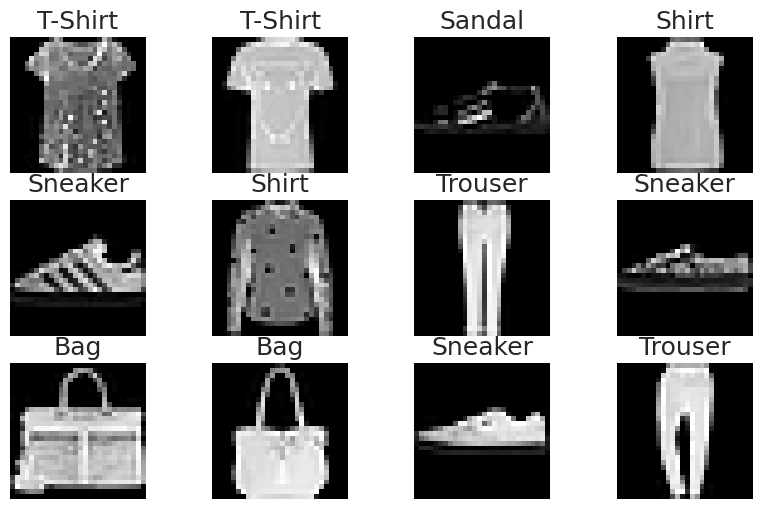

In [39]:
## Definimos el diccionario de etiquetas
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Esto lo puedo pasar a una funcion si lo voy a usar recurrentemente

## Construimos el gráfico
figure = plt.figure(figsize=(10, 6))
cols, rows = 4, 3
for i in range(1, cols*rows + 1):
    ## Elegimos muestras al azar para visualizar
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        ## El método squeeze elimina dimensiones con un
        ## sólo elemento. En este caso, la dimensión C
        ## (channel). Esta dimensión es trivial porque
        ## las imágenes son en escala de grises. Si fuese
        ## RGB, tendríamos 3 canales, uno para cada color.
        img.squeeze(), 
        cmap="gray"
    )
plt.show()

El dataset esta balanceado? 

In [40]:
train_labels = pd.Series([training_data[i][1] for i in range(len(training_data))])
test_labels = pd.Series([test_data[i][1] for i in range(len(test_data))])

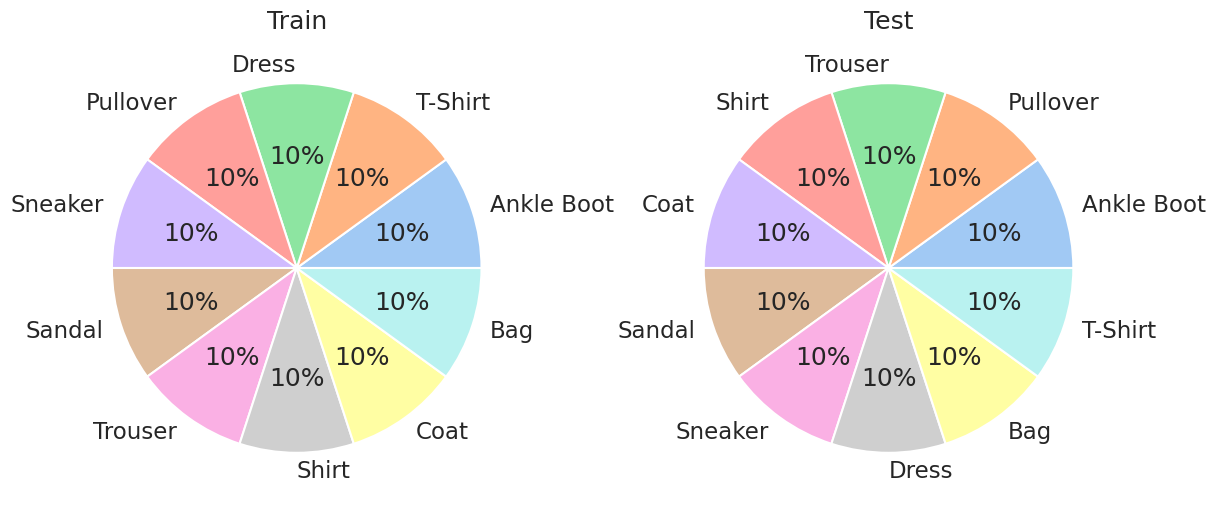

In [41]:
train_count= train_labels.value_counts()
test_count= test_labels.value_counts()
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(train_count)]
fig, ax = plt.subplots(1,2,figsize=(14,6))
#create pie chart
ax[0].pie(train_count, labels = train_count.index.map(labels_map), colors = colors, autopct='%.0f%%')
ax[0].set_title("Train")
ax[1].pie(test_count, labels = test_count.index.map(labels_map), colors = colors, autopct='%.0f%%')
ax[1].set_title("Test")
plt.show()
 

Pasamos el ``Dataset`` como argumento a  ``DataLoader``. De esta manera encapsulamos el dataset en un iterable que soporta varias operaciones útiles, como trabajar por batch, hacer sampling, paralelizar el cómputo, etc.

Elegimos un tamaño de batch de 64 ejemplos. Cada elemento que nos devuelva el iterable va a contener 64 ejemplos con sus atributos y sus etiquetas.

In [42]:
batch_size = 64

## Creamos los data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Dimensiones de X [N, C, H, W]: ", X.shape)
    print("Dimensiones de y: ", y.shape, y.dtype)
    break

Dimensiones de X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Dimensiones de y:  torch.Size([64]) torch.int64


<a id="creacion_modelo"></a>
## 3. Creamos el modelo

Todos los modelos en `pytorch` se definen como subclases de una clase genérica llamada `Module`.

Nuestro **primer modelo** será una red de tipo **perceptrón multicapa**, con una capa oculta y función de activación de tipo **Rectified Linear Unit (ReLU)**.

![picture](https://static.packt-cdn.com/products/9781786468574/graphics/B05474_04_05.jpg)


El segundo modelo será una **red convolucional profunda**, con la misma función de activación

![picture](https://miro.medium.com/max/2000/1*7K4ZTTfZb-hbjoADbisHAg.png)

<a id="modelo1"></a>
### 3.1 Red con una unica capa oculta

In [43]:
## Definimos el primer modelo
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()

        ## "Achatamos" la matriz de 28x28 píxeles, 
        ## transformandola en un vector de 784 elementos
        self.flatten = nn.Flatten()

        ## Definimos el perceptrón multicapa con las
        ## siguientes capas:
        ##
        ## Entrada:        784 neuronas
        ## 1º capa oculta: 512 neuronas
        ## Salida:         10  neuronas
        ##
        ## Entre capa y capa, utilizamos función de 
        ## activación ReLU
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x


<a id="modelo2"></a>
### 3.2 Red convolucional

In [44]:

## Definimos el segundo modelo
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ## Primera capa convolucional:
        ## construimos 32 canales usando filtros (kernels) de 3x3
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=3,                                 
                padding=1,                  
            ),
            ## Aplicamos Batch Normalization como regularización
            nn.BatchNorm2d(32),
            ## Aplicamos la función de activación               
            nn.ReLU(),      
            ## Reducimos la imagen con Max Pooling                  
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )

        ## Segunda capa convolucional:
        ## construimos 64 canales usando filtros (kernels) de 3x3
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,                               
                padding=0
            ),    
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),                
        )

        ## "Achatamos" la salida de la última capa, de 64 canales 
        ## de tamaño 6x6, transformandola en un vector de 64*6*6 elementos
        self.flatten = nn.Flatten()

        ## Después de las capas convoulucionales,
        ## agregamos algunas capas densas. La última, de 10
        ## neurnonas, es nuestra capa de salida
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 6 * 6, 600),
            nn.Dropout(0.25), 
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.Dropout(0.25), ## Regularizamos con dropout después de cada capa
            nn.ReLU(),
            nn.Linear(120, 10),
            nn.Dropout(0.25), 
            nn.ReLU() 
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)     
        x = self.linear_relu_stack(x)
        return x


In [45]:

## Creamos una instancia de nuestro modelo
## (un objeto de la clase correspondiente)
#
# model = MultiLayerPerceptron()
# model_name = "MLP" # Multi Layer Perceptron
#
model = CNN()
model_name = "CNN" # Convolutional Neuronal Network

## "enviamos" el modelo a la GPU o a la CPU, 
## según esté disponible
model.to(device)

print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=120, bias=True)
    (4): Dropout(p=0.25, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=120, out_features=10, bias=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Re

## Entrenamiento del modelo

Para entrenar el modelo, necesitamos definir una `función error` (loss function) y un `optimizador` (el algoritmo que intentará minimizar el error).

La función de costo que elegimos es la *Cross Entropy*, y el optimizador que elegimos es *Adam*.

In [46]:
## Definimos la función error o "loss"
loss_fn = nn.CrossEntropyLoss()
loss_fn_name = 'CrossEntropy'

## Definimos el optimizador
## Una opción es usar el SGD

# learning_rate = 1e-2 
# momentum = 0.5
# sgd_optimizer = torch.optim.SGD(
#    model.parameters(), 
#    lr=learning_rate, 
#    momentum=momentum
# )

# Otra opción es Adam
learning_rate = 0.001
adam_optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)

## Para la red Feed-Forward elegimos este
# optimizer = sgd_optimizer

## Para la CNN funciona mejor este
optimizer = adam_optimizer

Para cada ciclo de entrenamiento, el modelo hace predicciones sobre el conjunto de entrenamiento, el cual se presenta en lotes (batchs), y hace *backpropagation* del error obtenido para ajustar los parámetros.

In [47]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Entrena el modelo una época.
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        batch_size = X.shape[0]
        
        ## Calculamos el error en la predicción
        pred = model(X)
        true = y
        loss = loss_fn(pred, true)

        ## Ajustamos los pesos haciendo backpropagation
        
        # Reiniciamos  los gradientes de los tensores optimizados. 
        # Se deben reiniciar los gradientes antes de calcular nuevos gradientes para evitar acumular gradientes de cálculos previos.
        optimizer.zero_grad()
        
        # Esta línea se utiliza para calcular los gradientes del error (o pérdida) con respecto a todos los parámetros 
        # que pueden ser entrenados (aprendidos) en la red neuronal. Esto se hace utilizando el algoritmo de retropropagación, 
        # que propaga el error hacia atrás a través de la red, calculando la derivada de la pérdida con respecto a cada parámetro.
        loss.backward()
        #Esta línea se utiliza para actualizar los parámetros de la red neuronal utilizando los gradientes calculados en el paso anterior.
        # El optimizador se encarga de ajustar los parámetros según un algoritmo de optimización específico, 
        # como descenso de gradiente estocástico (SGD) o Adam.
        optimizer.step()
        
        if batch % 100 == 0:
            train_loss = loss.item() / batch_size
            current = batch * batch_size
            print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")
        

También evaluamos el desempeño del modelo con respecto al conjunto de validación para asegurarnos de que esté aprendiendo.


In [48]:
def test(dataloader, model, loss_fn, verbose=True):
    """
    Evalúa el modelo sobre los datos presentados en el parámetro "dataloader",
    y calcula las métricas correspondientes.
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    accuracy = 100*correct
    if verbose:
      print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f}")

    return test_loss, accuracy

El proceso de entrenamiento se lleva a cabo en iteraciones llamadas épocas. Durante cada época, el modelo ajusta los parámetros para mejorar la predicción.

Imprimimos la precisión del modelo y la loss para cada época. Lo ideal es que la predicción aumente y que la loss disminuya con cada época.

In [49]:
epochs = 100
train_losses = []
test_losses = []
train_acc_values = []
test_acc_values = []
for epoch in range(1, epochs+1):
    print(f'Época {epoch}')
    ## Entreno una época del modelo
    train(train_dataloader, model, loss_fn, optimizer)

    ## Evaluo sobre el consjunto de entrenamiento
    print()
    print('Train performance:')
    train_loss, train_acc = test(train_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    train_acc_values.append(train_acc)

    ## Evaluo sobre el conjunto de evaluación
    print('Test performance:')
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
    test_acc_values.append(test_acc)
    print('-------------------------------------')
    print()

print("Done!")


Época 1
loss: 0.036068  [    0/60000]
loss: 0.016661  [ 6400/60000]
loss: 0.013071  [12800/60000]
loss: 0.015394  [19200/60000]
loss: 0.016325  [25600/60000]
loss: 0.015735  [32000/60000]
loss: 0.014703  [38400/60000]
loss: 0.016165  [44800/60000]
loss: 0.016215  [51200/60000]
loss: 0.012831  [57600/60000]

Train performance:
Accuracy: 87.29%, Avg loss: 0.006749
Test performance:
Accuracy: 86.19%, Avg loss: 0.007331
-------------------------------------

Época 2
loss: 0.014774  [    0/60000]
loss: 0.010076  [ 6400/60000]
loss: 0.010124  [12800/60000]
loss: 0.018389  [19200/60000]
loss: 0.013696  [25600/60000]
loss: 0.013783  [32000/60000]
loss: 0.009992  [38400/60000]
loss: 0.019373  [44800/60000]
loss: 0.015657  [51200/60000]
loss: 0.012270  [57600/60000]

Train performance:
Accuracy: 90.46%, Avg loss: 0.006120
Test performance:
Accuracy: 88.80%, Avg loss: 0.006802
-------------------------------------

Época 3
loss: 0.015700  [    0/60000]
loss: 0.013663  [ 6400/60000]
loss: 0.010123

## Guardamos el modelo

Una forma estándar de guardar el modelo es "serializar" el diccionario con el estado interno del mismo, el cual contiene los parámetros del modelo.

In [50]:
filename_model = model_name+"-model.pth"

# torch.save(model.state_dict(),filename_model)
# print("Saved PyTorch Model State to "+filename_model)

## Guardamos las curvas

In [51]:
filename_curvas = model_name+"-curvas.pkl"

with open(filename_curvas,'wb') as fh:
    pickle.dump((train_losses,test_losses,train_acc_values,test_acc_values),fh)

## Cargamos un modelo guardado

Para cargar un modelo almacenado, tenemos que recrear la estructura del modelo (definir una nueva instancia de nuestra clase) y cargar el diccionario con el estado interno (los parámetros).

In [52]:
# model = MultiLayerPerceptron().to(device)
model = CNN().to(device)
model.load_state_dict(torch.load(filename_model))

<All keys matched successfully>

## Cargamos las curvas

In [53]:
# solo para revisar modelos pre entrenados
# filename_curvas = 'CNN-curvas.pkl'

In [54]:

with open (filename_curvas,'rb') as fh:
    train_losses,test_losses,train_acc_values,test_acc_values = pickle.load(fh)

## Observamos las predicciones

In [64]:
def plot_img(data, idx):
    """
    Grafica un ejemplo
    """
    figure = plt.figure(figsize=(4, 4))
    img, label = data[idx]
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

def show_prediction(example):
    """
    Muestra la predicción para un ejemplo
    """
    model.eval()
    x, y = test_data[example][0], test_data[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]
    print(
        f'Etiqueta correcta: {labels_map[y]}', 
        end='\n----------------\n'
    )
    print('Etiqueta     Probabilidad')
    for v, idx in list(zip(values,indices))[::-1]:
        label_pred = labels_map[idx.item()]
        print(f'{label_pred:13}{v.item():.5f}')

In [203]:
def show_prediction2(data,example):
    import seaborn as sns
    """
    Muestra la predicción para un ejemplo
    """
    # imagen considerada
    
    img, label = data[example]
    # prediccion
    model.eval()
    x, y = test_data[example][0], test_data[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]

    indices = np.array(indices)
    
    def map_values(indices, dictionary):
        values = []
        for i in indices:
            
            values.append(dictionary[i])
        return values

    # print(indices,map_values(indices,labels_map))
    #plots
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Primer subplot
    axs[0].imshow(img.squeeze(), cmap="gray")
    axs[0].set_axis_off()
    axs[0].set_title('Imagen Original')

    # Segundo subplot
    axs[1].barh(map_values(indices,labels_map),values,label='probs')
    
    for i, v in enumerate(values.numpy()):
        axs[1].text( v+v*0.1,i, str(round(v,2)), ha='center',fontsize=9)
        
    axs[1].set_title('Prediccion')
    axs[1].legend(loc='lower right')
    # Ajustar los espacios entre subplots y guardar la figura
    fig.tight_layout()
    


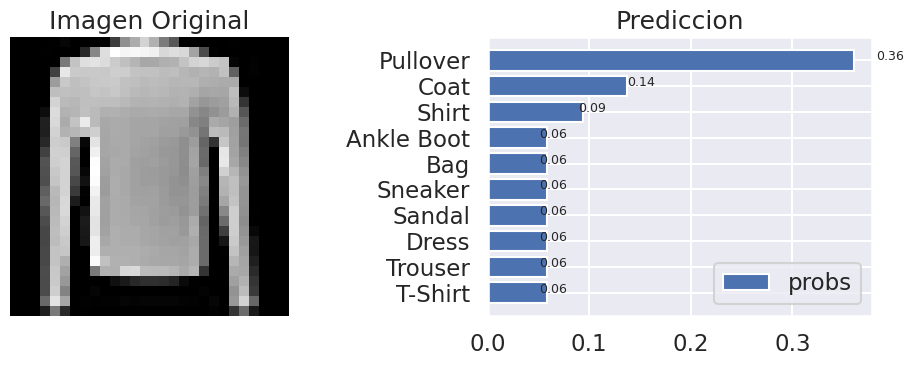

In [213]:
example = np.random.randint(0,1000)
# plot_img(test_data, example)
show_prediction2(test_data,example)

In [156]:
np.random.randint(0,1000)

11

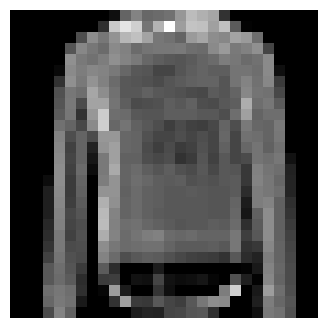

Etiqueta correcta: Pullover
----------------
Etiqueta     Probabilidad
Shirt        0.21433
Coat         0.20407
Pullover     0.17057
Ankle Boot   0.05872
Bag          0.05872
Sneaker      0.05872
Sandal       0.05872
Dress        0.05872
Trouser      0.05872
T-Shirt      0.05872


In [73]:
# example = 16
# plot_img(test_data, example)
# show_prediction(example)

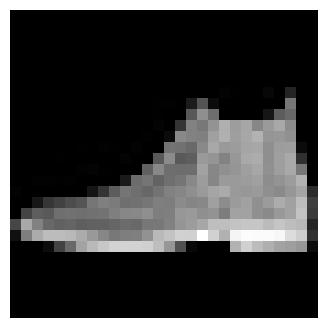

Etiqueta correcta: Ankle Boot
----------------
Etiqueta     Probabilidad
Ankle Boot   0.97685
Sneaker      0.00287
Bag          0.00253
Shirt        0.00253
Sandal       0.00253
Coat         0.00253
Dress        0.00253
Pullover     0.00253
Trouser      0.00253
T-Shirt      0.00253


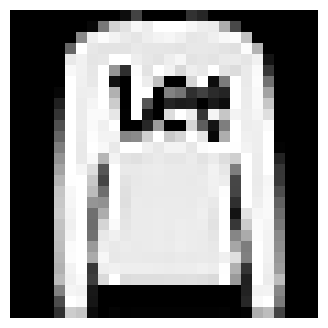

Etiqueta correcta: Pullover
----------------
Etiqueta     Probabilidad
Pullover     0.65949
Coat         0.10256
Shirt        0.03292
Ankle Boot   0.02929
Bag          0.02929
Sneaker      0.02929
Sandal       0.02929
Dress        0.02929
Trouser      0.02929
T-Shirt      0.02929


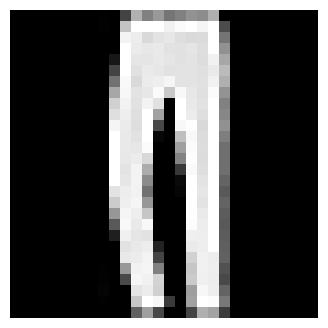

Etiqueta correcta: Trouser
----------------
Etiqueta     Probabilidad
Trouser      1.00000
Ankle Boot   0.00000
Bag          0.00000
Sneaker      0.00000
Shirt        0.00000
Sandal       0.00000
Coat         0.00000
Dress        0.00000
Pullover     0.00000
T-Shirt      0.00000


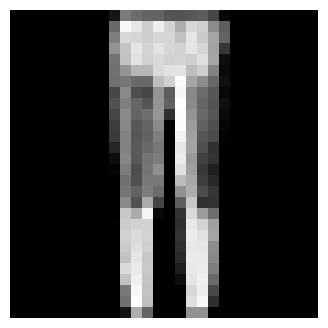

Etiqueta correcta: Trouser
----------------
Etiqueta     Probabilidad
Trouser      1.00000
Ankle Boot   0.00000
Bag          0.00000
Sneaker      0.00000
Shirt        0.00000
Sandal       0.00000
Coat         0.00000
Dress        0.00000
Pullover     0.00000
T-Shirt      0.00000


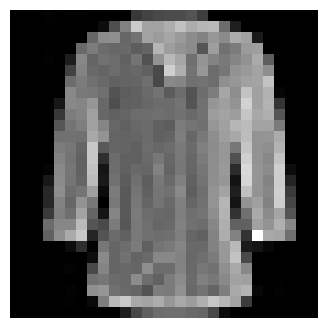

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Shirt        0.71131
Coat         0.04228
Ankle Boot   0.03080
Bag          0.03080
Sneaker      0.03080
Sandal       0.03080
Dress        0.03080
Pullover     0.03080
Trouser      0.03080
T-Shirt      0.03080


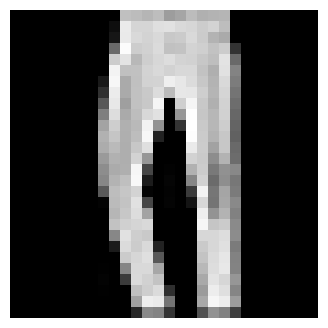

Etiqueta correcta: Trouser
----------------
Etiqueta     Probabilidad
Trouser      1.00000
Ankle Boot   0.00000
Bag          0.00000
Sneaker      0.00000
Shirt        0.00000
Sandal       0.00000
Coat         0.00000
Dress        0.00000
Pullover     0.00000
T-Shirt      0.00000


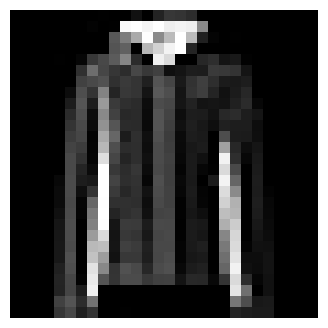

Etiqueta correcta: Coat
----------------
Etiqueta     Probabilidad
Coat         0.80206
Shirt        0.06362
Ankle Boot   0.01679
Bag          0.01679
Sneaker      0.01679
Sandal       0.01679
Dress        0.01679
Pullover     0.01679
Trouser      0.01679
T-Shirt      0.01679


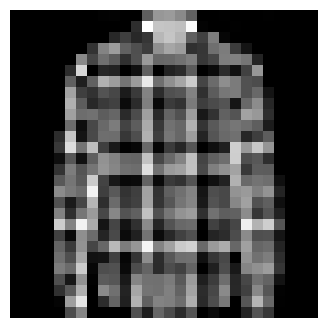

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Shirt        0.76759
Coat         0.07268
Ankle Boot   0.01997
Bag          0.01997
Sneaker      0.01997
Sandal       0.01997
Dress        0.01997
Pullover     0.01997
Trouser      0.01997
T-Shirt      0.01997


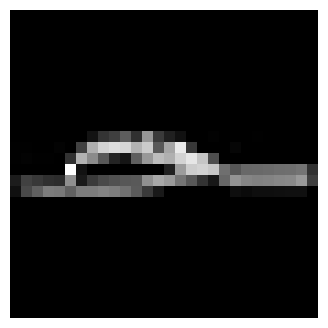

Etiqueta correcta: Sandal
----------------
Etiqueta     Probabilidad
Sandal       0.94469
Ankle Boot   0.00615
Bag          0.00615
Sneaker      0.00615
Shirt        0.00615
Coat         0.00615
Dress        0.00615
Pullover     0.00615
Trouser      0.00615
T-Shirt      0.00615


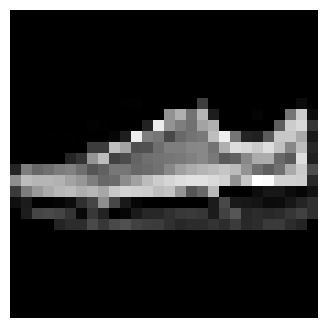

Etiqueta correcta: Sneaker
----------------
Etiqueta     Probabilidad
Sneaker      0.99942
Ankle Boot   0.00006
Bag          0.00006
Shirt        0.00006
Sandal       0.00006
Coat         0.00006
Dress        0.00006
Pullover     0.00006
Trouser      0.00006
T-Shirt      0.00006


In [75]:
for i in range(10):
    
    plot_img(test_data, i)
    show_prediction(i)

## Analizamos el proceso de aprendizaje

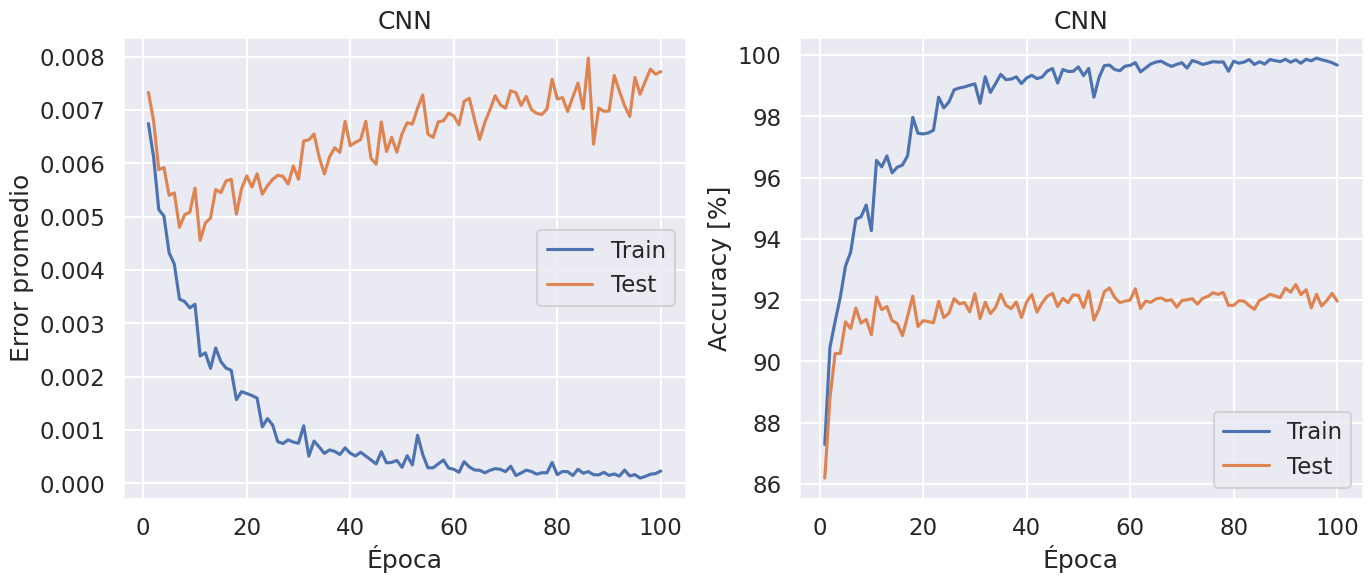

In [57]:
X = range(1, len(train_losses)+1)

fig, axes = plt.subplots(figsize=(16, 6), ncols=2)
ax = axes[0]
ax.set_xlabel('Época')
ax.set_ylabel('Error promedio')
ax.plot(X, train_losses, label='Train')
ax.plot(X, test_losses, label='Test')
ax.set_title(model_name)
ax.legend()

ax = axes[1]
ax.set_xlabel('Época')
ax.set_ylabel('Accuracy [%]')
ax.plot(X, train_acc_values, label='Train')
ax.plot(X, test_acc_values, label='Test')
ax.set_title(model_name)
ax.legend()
plt.show()

In [58]:
# train_data = pd.Series([training_data[i][0] for i in range(len(training_data))])

In [59]:
# import numpy as np
# from sklearn.datasets import make_classification
# from torch import nn

# from skorch import NeuralNetClassifier
# import torch
# import torch.nn as nn
# from torch.optim import Adam
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# from sklearn.model_selection import GridSearchCV

# # Define la arquitectura de la red neuronal
# class CNN(nn.Module):
#     def __init__(self,padding=1):
#         super().__init__()
        
#         self.padding = padding
#         ## Primera capa convolucional:
#         ## construimos 32 canales usando filtros (kernels) de 3x3
#         self.conv1 = nn.Sequential(         
#             nn.Conv2d(
#                 in_channels=1,              
#                 out_channels=32,            
#                 kernel_size=3,                                 
#                 padding=self.padding,                  
#             ),
#             ## Aplicamos Batch Normalization como regularización
#             nn.BatchNorm2d(32),
#             ## Aplicamos la función de activación               
#             nn.ReLU(),    
#             ## Reducimos la imagen con Max Pooling                  
#             nn.MaxPool2d(kernel_size=2, stride=2),    
#         )

#         ## Segunda capa convolucional:
#         ## construimos 64 canales usando filtros (kernels) de 3x3
#         self.conv2 = nn.Sequential(         
#             nn.Conv2d(
#                 in_channels=32,              
#                 out_channels=64,            
#                 kernel_size=3,                               
#                 padding=0
#             ),    
#             nn.BatchNorm2d(64),
#             nn.ReLU(),                      
#             nn.MaxPool2d(kernel_size=2, stride=2),                
#         )

#         ## "Achatamos" la salida de la última capa, de 64 canales 
#         ## de tamaño 6x6, transformandola en un vector de 64*6*6 elementos
#         self.flatten = nn.Flatten()

#         ## Después de las capas convoulucionales,
#         ## agregamos algunas capas densas. La última, de 10
#         ## neurnonas, es nuestra capa de salida
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(64 * 6 * 6, 600),
#             nn.Dropout(0.25), 
#             nn.ReLU(),
#             nn.Linear(600, 120),
#             nn.Dropout(0.25), ## Regularizamos con dropout después de cada capa
#             nn.ReLU(),
#             nn.Linear(120, 10),
#             nn.Dropout(0.25), 
#             nn.ReLU() 
#         )

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.flatten(x)     
#         x = self.linear_relu_stack(x)
#         return x

# # Carga los datos de entrenamiento y de prueba

# # Define los parámetros a probar en la búsqueda de rejilla
# param_grid = {'lr': [0.001, 0.01],
#               'max_epochs': list(range(3, 7, 1)),}
#             #   "module_pading" : [1,2]}

# # Define el modelo, la función de pérdida y el optimizador
# model = CNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam

# net = NeuralNetClassifier(
#     module = CNN,
#     max_epochs=3,
#     criterion=criterion,
#     lr=0.001,
#     # Shuffle training data on each epoch
#     iterator_train__shuffle=True,
#     optimizer=optimizer
# )
# counter = 0
# # Run each fit for 2 batches. So, if we have `n` fits, then it will
# # actually for `n*2` times. We have 672 fits, so total, 
# # 672 * 2 = 1344 runs.
# search_batches = 10
# """
# This will run `n` (`n` is calculated from `params`) number of fits 
# on each batch of data, so be careful.
# If you want to run the `n` number of fits just once, 
# that is, on one batch of data,
# add `break` after this line:
#     `outputs = gs.fit(image, labels)`
# Note: This will take a lot of time to run
# """
# grid_search = GridSearchCV(net, param_grid, refit=False, scoring='accuracy', cv=5, n_jobs=-1)

# for i, data in enumerate(train_dataloader):
#     counter += 1
#     image, labels = data
#     image = image.to(device)
#     labels = labels.to(device)
#     outputs = grid_search.fit(image, labels)
#     # GridSearch for `search_batches` number of times.
#     # if counter == search_batches:
#     #     print("ola")
#     #     break
    
    
# print('SEARCH COMPLETE')
# print("best score: {:.3f}, best params: {}".format(grid_search.best_score_, grid_search.best_params_))

# # # Crea el objeto GridSearchCV

# # # Entrena el modelo con la búsqueda de rejilla

# # grid_search.fit(train_data,train_labels,error_score='raise')
# # # Obtiene los mejores parámetros
# # best_params = grid_search.best_params_
# # net.get_params


In [60]:
# generar una lista con 10 numeros aleatorios
a,b = 1,2

In [61]:
list(range(2,4,6))


[2]

In [62]:

for i in range(int(1e8)):
    a = i

In [63]:
from numba import njit
@njit
for i in range(int(1e8)):
    a = i

SyntaxError: invalid syntax (2385651071.py, line 3)

In [ ]:
import time

def main():
    veces = int(1e7)
    num=1
    a = 0
    for a in range(veces):
        num = num + num - num
    print(num)
    
start = time.time()
main()
end = time.time()
print(end-start)

In [ ]:
import time
from numba import njit

@njit
def main():
    veces = int(1e12)
    num=1
    a = 0
    for a in range(veces):
        num = num + num - num
    print(num)
    
start = time.time()
main()
end = time.time()
print(end-start)

In [ ]:
# class fit():
#     def __init__(train_dataloader,test_dataloader,epochs):
    
    
    
#     epochs = 1
#     train_losses = []
#     test_losses = []
#     train_acc_values = []
#     test_acc_values = []
#     for epoch in range(1, epochs+1):
#         print(f'Época {epoch}')
#         ## Entreno una época del modelo
#         train(train_dataloader, model, loss_fn, optimizer)

#         ## Evaluo sobre el consjunto de entrenamiento
#         print()
#         print('Train performance:')
#         train_loss, train_acc = test(train_dataloader, model, loss_fn)
#         train_losses.append(train_loss)
#         train_acc_values.append(train_acc)

#         ## Evaluo sobre el conjunto de evaluación
#         print('Test performance:')
#         test_loss, test_acc = test(test_dataloader, model, loss_fn)
#         test_losses.append(test_loss)
#         test_acc_values.append(test_acc)
#         print('-------------------------------------')
#         print()

#     print("Done!")

#### Referencias:

[A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

[Documentación de PyTorch](https://pytorch.org/)

[Tutoriales](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)